In [1]:
print('testing')

testing


In [2]:

import asyncio
from langgraph.graph import StateGraph, START, END
from typing import Literal, TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
# from workflow.agentic_workflow_with_mcp_websearch import AgenticRAG
from retriever.retrieval import Retriever  
from retriever.conventional_retreiver import ConversationalRAG
from langchain_core.tools import tool
from dotenv import load_dotenv
import sqlite3
import requests
import structlog
import os
from langchain.tools import Tool

d:\LLMOPS Industry Projects\ecomm-prod-assistant\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
{"timestamp": "2025-10-15T00:37:36.304021Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-15T00:37:36.305770Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-15T00:37:36.307565Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-15T00:37:36.310807Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-10-15T00:37:36.312649Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-10-15T00:37:36.313809Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_

In [3]:
load_dotenv()
log = structlog.get_logger()
# -------------------
# 1. LLM
# -------------------
llm = ChatOpenAI()

retriever_obj = Retriever()
retriever = retriever_obj.load_retriever()

{"timestamp": "2025-10-15T00:38:45.993318Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-15T00:38:45.994635Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-15T00:38:45.995903Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-15T00:38:45.997184Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-10-15T00:38:45.998932Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-10-15T00:38:46.000069Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "sql_server", "llm", "security"], "timestamp": "2025-10-15T00:38:46.004747Z", "level": "info", "event": "YAML config loaded"}


Environment variables loaded successfully.


{"model": "text-embedding-3-small", "timestamp": "2025-10-15T00:38:46.016863Z", "level": "info", "event": "Loading embedding model"}


Embedding model loaded successfully.


vector store default init, collection 'prodassistant'
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
No valid keyspace found in environment variable.
Detecting API environment 'prod' from supplied endpoint
createCollection('prodassistant')
HTTP Request: POST https://a4b8925e-916e-4401-83a3-fad09ce1f6fa-us-east-2.apps.astra.datastax.com/api/json/v1/default_keyspace "HTTP/1.1 200 OK"
APICommander about to raise from: [{'message': "Collection already exists: trying to create Collection ('prodassistant') with different settings", 'errorCode': 'EXISTING_COLLECTION_DIFFERENT_SETTINGS', 'id': '1c127d02-ddab-46fa-9eb0-20f3dbb9e3b1', 'title': 'Collection already exists', 'family': 'REQUEST', 'scope': 'EMPTY'}]
findCollections
HTTP Request: POST https://a4b8925e-916e-4401-83a3-fad09ce1f6fa-us-east-2.apps.astra.datastax.com/api/json/v1/default_keyspace "HTTP/1.1 200 OK"
finished findCollections
d:\LLMOPS Industry Projects\ecomm-prod-assistant\.venv\lib\site-packages\lan

AstraDB Vector Store initialized successfully.
Retriever loaded successfully.


{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-10-15T00:38:49.054945Z", "level": "info", "event": "Loading LLM"}


In [4]:
def format_docs(docs) -> str:
    """Format retriever docs into readable context."""
    if not docs:
        return ""
    formatted_chunks = []
    for d in docs:
        meta = d.metadata or {}
        formatted = (
            f"Title: {meta.get('product_title', 'N/A')}\n"
            f"Price: {meta.get('price', 'N/A')}\n"
            f"Rating: {meta.get('rating', 'N/A')}\n"
            f"Reviews:\n{d.page_content.strip()}"
        )
        formatted_chunks.append(formatted)
    return "\n\n---\n\n".join(formatted_chunks)

In [5]:

# -------------------
# 2. Tools
# -------------------
# Tools
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}


In [6]:

def chat_with_agentic_rag(msg: str) -> str:
    """
    tool to search email history of support staff to find relevant information and answer to the support call and issues.
    
    
    """
    try:
        log.info("chat_with_agentic_rag called", msg)
        print("Calling Tool chat_with_agentic_rag")
        # retriever_obj = Retriever()
        # retriever = retriever_obj.load_retriever()
        # Import here to avoid circular imports
        docs =  retriever.invoke(msg)   
        print("Document retrieved", len(docs))
        context = format_docs(docs)
        return context
        
        # rag_agent = AgenticRAG()
        # answer = rag_agent.run(msg)
        
        # log.info("Agentic RAG response generated", answer_length=len(answer))
        # return answer
        
    except Exception as e:
        log.error("Error in chat_with_agentic_rag", error=str(e))
        return f"Error in agentic RAG: {str(e)}"

In [7]:
@tool    
def format_message(messages:str) :
    """
    Use this tool after receiving message from email tool chat_with_agentic_rag
    check email history from message of support staff to find relevant information and answer to the support call and issues and formate the message.
   
    
    """
    try:
        print("formatting message")
                
        prompt = """
         Reply one best Answer in proper professional email formate with below format and build message from given text {messages}
         
    
            Hi [name of Customer if exists then show],
            First say thanks on approaching us and regret message if user is facing some issue
            In message body address to given problem, text, message in {messages}
            
            Say thanks again
            
            regards 
           
            Adamas Chatobot
           
        """
        log.info("formatting email called")
        
       
        response = llm.invoke( prompt)
        if response :
            return {"messages": response.content}
        else :
            return {"message" : messages}
        
    except Exception as e:
        log.error("Error in formatting email", error=str(e))
        return f"Error in formatting email: {str(e)}"



In [46]:
tools = [search_tool,  chat_with_agentic_rag, format_message]
llm_with_tools = llm.bind_tools(tools)

In [10]:

# -------------------
# 3. State
# -------------------
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# -------------------
# 4. Nodes
# -------------------
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call. 
     call tool only once, format message from response coming from tool call
     If no message returned by tool then just format regret message with proper format"""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


In [40]:
def format_message_node(messages:str) :
    """
    Use this tool after receiving message from email tool chat_with_agentic_rag
    check email history from message of support staff to find relevant information and answer to the support call and issues and formate the message.
   
    
    """
    try:
        print("formatting message")
                
        prompt = """
         Reply one best Answer in proper professional email formate with below format and build message from given text {messages}
         
    
            Hi [name of Customer if exists then show],
            First say thanks on approaching us and regret message if user is facing some issue
            In message body address to given problem, text, message in {messages}
            
            Say thanks again
            
            regards 
           
            Adamas Chatobot
           
        """
        log.info("formatting email called")
        
       
        response = llm.invoke( prompt)
        if response :
            return {"messages": response.content}
        else :
            return {"message" : messages}
        
    except Exception as e:
        log.error("Error in formatting email", error=str(e))
        return f"Error in formatting email: {str(e)}"


In [16]:

def should_continue(state: ChatState) -> Literal["tools", "end"]:
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there are tool calls, route to tools
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    # Otherwise, end
    return "end"

In [54]:
tool_node = ToolNode(tools)

# -------------------
# 5. Checkpointer
# -------------------
conn = sqlite3.connect(database="chatbot.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

# -------------------
# 6. Graph
# -------------------
# Build graph
graph = StateGraph(ChatState)

# Add nodes
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)
# graph.add_node("format_message_node", format_message_node)


# Add edges
graph.add_edge(START, "chat_node")



# Conditional edges: should_continue returns "tools" or "end"
# The dictionary maps these return values to destinations
graph.add_conditional_edges(
    "chat_node",          # Source node
    should_continue,      # Function that returns "tools" or "end"
    {
        "tools": "tools", # If returns "tools", go to "tools" node
        "end": END        # If returns "end", go to END
    }
)

# After tools execute, always go back to chat_node
graph.add_edge("tools", "chat_node")
# graph.add_edge("chat_node", "format_message_node")
# graph.add_edge("format_message_node", END)

In [55]:
chatbot = graph.compile(checkpointer=checkpointer)


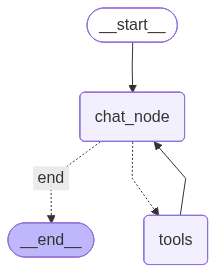

In [56]:
chatbot

In [58]:
state = {
        'messages': [
            HumanMessage(
                content="RE: URGENT: Critical Server Connection Issue with App Version 25.08.001 [ITR:0015942]?"
            )
        ]
    }
# Add config with thread_id
config = {
    "configurable": {
        "thread_id": "conversation_101"  # Unique identifier for this conversation
    }
}

# Invoke with config
result = chatbot.invoke(state, config=config)
print(result["messages"][-1].content)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{"error": "not all arguments converted during string formatting", "timestamp": "2025-10-15T01:38:58.888843Z", "level": "error", "event": "Error in chat_with_agentic_rag"}
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{"error": "not all arguments converted during string formatting", "timestamp": "2025-10-15T01:39:00.430262Z", "level": "error", "event": "Error in chat_with_agentic_rag"}
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


formatting message


{"timestamp": "2025-10-15T01:39:03.776875Z", "level": "info", "event": "formatting email called"}
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Here is a formatted message based on the email context:

---

Subject: Re: Assistance with Critical Server Connection Issue

Hi,

First of all, thank you for reaching out to us. We are sorry to hear that you are facing some issues.

In regard to the problem you mentioned in your message "RE: URGENT: Critical Server Connection Issue with App Version 25.08.001 [ITR:0015942]", our team is working diligently to find a solution for you as quickly as possible. We understand how frustrating it can be to encounter difficulties, and we appreciate your patience.

Thank you again for bringing this matter to our attention. If you have any further information or questions, please feel free to reach out.

Regards,

Adamas Chatobot

---

Please review the message before sending it to ensure it aligns with the context of the support call.
